# 3. Data analysis

In [16]:
from IPython.display import display, HTML
import matplotlib as mpl
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import statsmodels.tsa.stattools as tsa
import pandas as pd
import seaborn as sns
sns.set(style='ticks', rc={'axes.grid':True,
                           'xtick.labelsize': 'medium',
                           'ytick.labelsize': 'medium',
#                            'font.size': 15,
                          })
# mpl.rcParams.update({'font.size': 15})
# plt.rc('ytick', labelsize='small') 


# assume the notebook is in the right place and set up the plot path
analysis_dir = _dh[0]
assert analysis_dir.endswith(os.path.join('em-2020','analysis'))
plot_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'tex', 'plots'))
data_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'data'))

In [17]:
SAVE = True

def save_table(table, file, **kwargs):
    if SAVE:
        path = os.path.join(plot_dir, file)
        with open(path, 'w') as fd:
            fd.write(table.to_latex(**kwargs))
        
def save_fig(file, **kwargs):
    if SAVE:
        path = os.path.join(plot_dir, file)
        plt.savefig(path)
        
def load_data(country, version='current'):
    data_file = os.path.join(data_dir, 'WB_{}_{}.csv'.format(country, version))
    data_raw = pd.read_csv(data_file, index_col='year')
    if 'EIb' in data_raw:
        return data_raw[['ISG', 'TO', 'TI', 'P_GDP', 'EI', 'EIb']]
    else:
        return data_raw[['ISG', 'TO', 'TI', 'P_GDP', 'EI']]
    
def summary_stats(data, country, version):
    stats = ref_data.describe().T[['min', 'max', 'mean', 'std', 'count']]
    stats['count'] = stats['count'].astype(int)
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(stats)
        print(stats.to_latex())
#         save_table(stats, '_'.join((country, version, 'descriptive_statistics.tex')))

In [18]:
def plot_corr(data, figsize=None, **kwargs):
    corr = data.corr(lambda x, y: scipy.stats.pearsonr(x,y)[0])
    significance = data.corr(lambda x, y: scipy.stats.pearsonr(x,y)[1])
    corr_text = corr.applymap('{:.3f}'.format) + np.where(significance < .01, '*', '')

    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    if figsize is None:
        figsize=np.array([1, 0.75]) * corr.shape[0] + np.array([kwargs.get('cbar', True) * 1.5, 0])
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, s=50, l=85, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=corr_text, fmt='', mask=mask, cmap=cmap, 
                square=False, linewidths=.25, **kwargs)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'verticalalignment': 'center'})

In [173]:
countries = ['BGD', 'IND', 'GBR']
raw_data = pd.concat([load_data(c, 'current') for c in countries],
                     keys=countries, names=['country', 'year'])
cmp_data = raw_data.loc[pd.IndexSlice[:, 1986:], :]

In [20]:
cmp_data.groupby(level='country').describe().T.xs('mean', level=1)

country,BGD,GBR,IND
ISG,23.470421,21.592732,28.070682
TO,31.156640,53.167799,32.523293
TI,248.181818,26839.393939,20974.454545
P_GDP,608.823333,31897.401171,813.043737
EI,0.351282,0.137837,0.803261
EIb,NaN,0.096291,0.142844


In [21]:
cmp_data[['EI', 'EIb', 'P_GDP', 'TI']] = np.log(cmp_data[['EI', 'EIb', 'P_GDP', 'TI']])


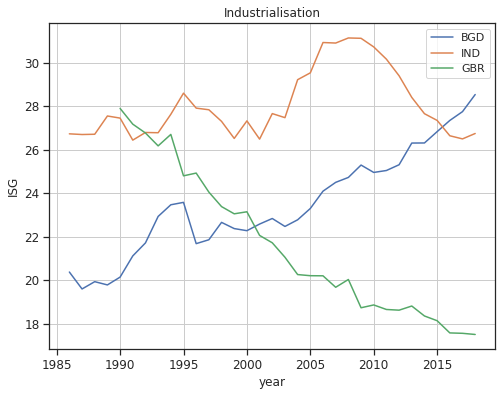

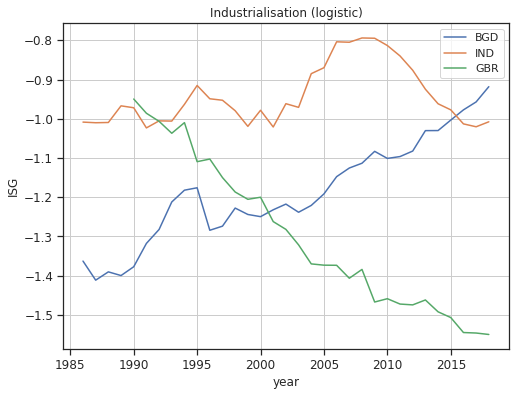

In [22]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['ISG'].unstack(level=0).plot(ax=ax)
plt.title('Industrialisation')
plt.ylabel('ISG')
plt.legend(loc='best')
save_fig('ISG_timeseries.pdf')

f, ax = plt.subplots(figsize=(8, 6))
x = cmp_data['ISG'].unstack(level=0)
plt.title('Industrialisation (logistic)')
np.log(x / (100-x)).plot(ax=ax, grid=True)
plt.ylabel('ISG')
plt.legend(loc='best')


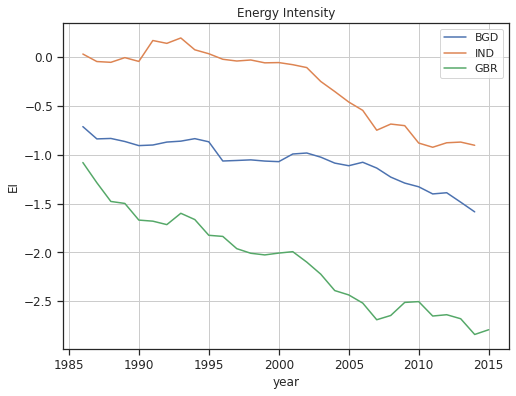

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['EI'].unstack(level=0).plot(ax=ax)
plt.title('Energy Intensity')
plt.ylabel('EI')
plt.legend(loc='best')
save_fig('EI_timeseries.pdf')

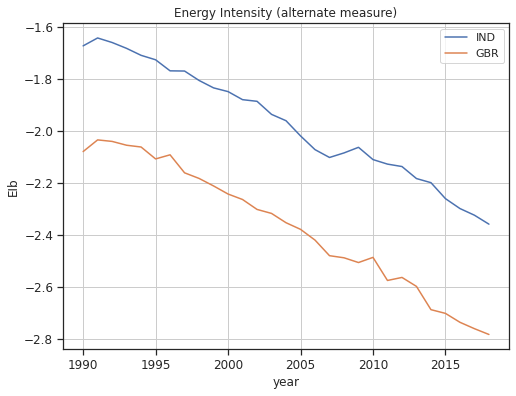

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['EIb'].unstack(level=0)[['IND', 'GBR']].plot(ax=ax)
plt.title('Energy Intensity (alternate measure)')
plt.ylabel('EIb')
plt.legend(loc='best')
save_fig('EIb_timeseries.pdf')

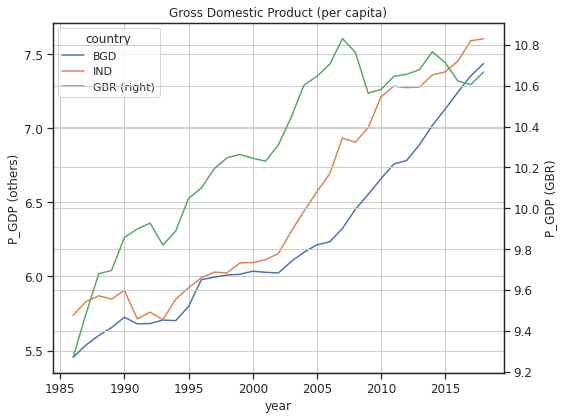

In [25]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['P_GDP'].unstack(level=0).plot(ax=ax, secondary_y='GBR', grid=True)
plt.title('Gross Domestic Product (per capita)')
plt.ylabel('P_GDP (GBR)')
ax.set_ylabel('P_GDP (others)')
plt.tight_layout()
save_fig('P_GDP_timeseries.pdf')

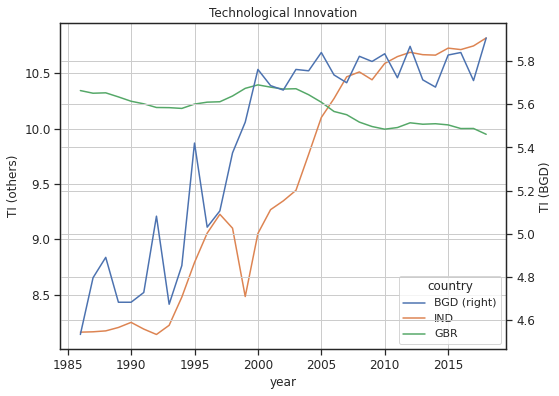

In [26]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['TI'].unstack(level=0).plot(ax=ax, secondary_y='BGD', grid=True)
plt.title('Technological Innovation')
plt.ylabel('TI (BGD)')
ax.set_ylabel('TI (others)')
save_fig('TI_timeseries.pdf')

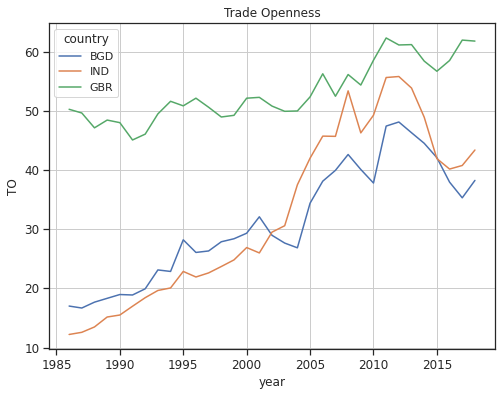

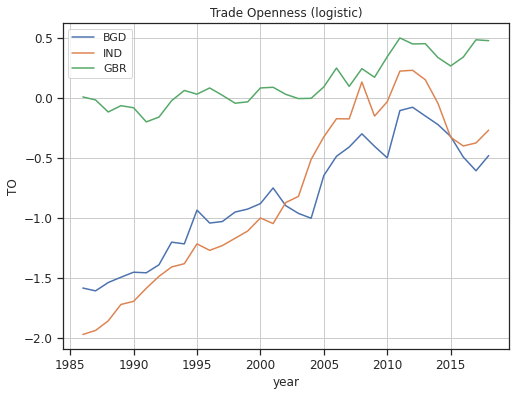

In [27]:
f, ax = plt.subplots(figsize=(8, 6))
cmp_data['TO'].unstack(level=0).plot(ax=ax, grid=True)
plt.title('Trade Openness')
plt.ylabel('TO')
save_fig('TO_timeseries.pdf')

f, ax = plt.subplots(figsize=(8, 6))
x = cmp_data['TO'].unstack(level=0)
plt.title('Trade Openness (logistic)')
np.log(x / (100-x)).plot(ax=ax, grid=True)
plt.ylabel('TO')
plt.legend(loc='best')

In [165]:
def adf(x, index=1):
    try:
        return tsa.adfuller(x.dropna(), regression='ct', autolag='AIC')[index]
    except:
        return np.nan

by_country_var = cmp_data.stack().groupby(level=[0,2])
adf_stat = by_country_var.apply(adf, 0).unstack()
adf_pval = by_country_var.apply(adf, 1).unstack()
display(adf_stat.round(3))
f3n = lambda x: '{:.3f}'.format(x) if np.isfinite(x) else ''
display(adf_pval.round(3))
print(adf_pval.reset_index().to_latex(float_format=f3n, index=False))

,EI,EIb,ISG,P_GDP,TI,TO
country,,,,,,
BGD,-2.361,NaN,-1.867,4.640,-2.816,-2.276
GBR,0.297,-4.832,-2.376,-3.542,-1.547,-3.260
IND,-0.831,-2.557,-4.235,-0.855,-2.813,-3.766


,EI,EIb,ISG,P_GDP,TI,TO
country,,,,,,
BGD,0.401,NaN,0.672,1.000,0.191,0.447
GBR,0.996,0.0,0.393,0.035,0.813,0.073
IND,0.963,0.3,0.004,0.961,0.192,0.018


\begin{tabular}{lrrrrrr}
\toprule
country &    EI &   EIb &   ISG &  P\_GDP &    TI &    TO \\
\midrule
    BGD & 0.401 &       & 0.672 &  1.000 & 0.191 & 0.447 \\
    GBR & 0.996 & 0.000 & 0.393 &  0.035 & 0.813 & 0.073 \\
    IND & 0.963 & 0.300 & 0.004 &  0.961 & 0.192 & 0.018 \\
\bottomrule
\end{tabular}



In [163]:
x = cmp_data.xs('BGD', level='country')['TI']
display(tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', regresults=False))
r = tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', regresults=True)
r[-1].resols.params

(-2.816221859691976,
 0.19105014355143385,
 0,
 32,
 {'1%': -4.27353517944336,
  '5%': -3.5578989233398435,
  '10%': -3.2123659912109375},
 214.8844319484408)

array([-0.43067003, 54.776683  ,  3.58114991])

In [158]:
log_data = raw_data.copy()
log_data[['EI', 'EIb', 'P_GDP', 'TI']] = np.log(log_data[['EI', 'EIb', 'P_GDP', 'TI']])
logdiff_data = log_data.groupby(level='country').diff().loc[pd.IndexSlice[:, 1986:], :]
logdiff_data

ISG        TO        TI     P_GDP        EI       EIb
country year                                                            
BGD     1986  0.057351 -1.203442 -0.380055 -0.049250  0.091232       NaN
        1987 -0.778197 -0.330945  0.263191  0.083375 -0.125358       NaN
        1988  0.335391  0.990267  0.094559  0.063776  0.004645       NaN
        1989 -0.149502  0.647110 -0.208218  0.054385 -0.031072       NaN
        1990  0.358919  0.641328  0.000000  0.069068 -0.042025       NaN
...                ...       ...       ...       ...       ...       ...
GBR     2015 -0.217864 -1.715294 -0.010427 -0.053085  0.048442 -0.014315
        2016 -0.560478  1.815189 -0.033084 -0.090530       NaN -0.034376
        2017 -0.018522  3.446853  0.000589 -0.017505       NaN -0.024615
        2018 -0.053352 -0.168631 -0.052601  0.062020       NaN -0.022366
        2019       NaN       NaN       NaN       NaN       NaN       NaN

[102 rows x 6 columns]

In [162]:
by_country_var = logdiff_data.stack().groupby(level=[0,2])
adf_stat = by_country_var.apply(adf, 0).unstack()
adf_pval = by_country_var.apply(adf, 1).unstack()
display(adf_pval.round(3))
f3n = lambda x: '{:.3f}'.format(x) if np.isfinite(x) else ''
print(adf_pval.reset_index().to_latex(float_format=f3n, index=False))

,EI,EIb,ISG,P_GDP,TI,TO
country,,,,,,
BGD,0.000,NaN,0.006,0.002,0.000,0.990
GBR,0.976,0.244,0.000,0.000,0.017,0.006
IND,0.000,0.000,0.697,0.000,0.000,0.000


\begin{tabular}{lrrrrrr}
\toprule
country &    EI &   EIb &   ISG &  P\_GDP &    TI &    TO \\
\midrule
    BGD & 0.000 &       & 0.006 &  0.002 & 0.000 & 0.990 \\
    GBR & 0.976 & 0.244 & 0.000 &  0.000 & 0.017 & 0.006 \\
    IND & 0.000 & 0.000 & 0.697 &  0.000 & 0.000 & 0.000 \\
\bottomrule
\end{tabular}



In [184]:
gbr_ei = np.log(raw_data.xs('GBR', level='country')[['EI']])
gbr_ei['dEI'] = gbr_ei['EI'].diff()
gbr_ei['ddEI'] = gbr_ei['dEI'].diff()
gbr_ei['dddEI'] = gbr_ei['ddEI'].diff()

gbr_ei.loc[1986:].apply(lambda x:
    tsa.adfuller(x.dropna(), regression='ct', autolag='AIC', regresults=False)[1])

EI       0.041495
dEI      0.976150
ddEI     0.889246
dddEI    0.005267
dtype: float64

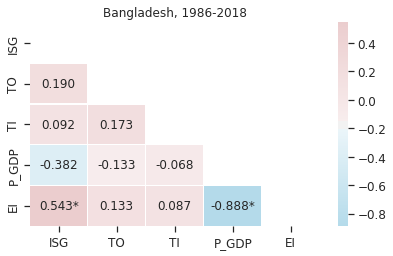

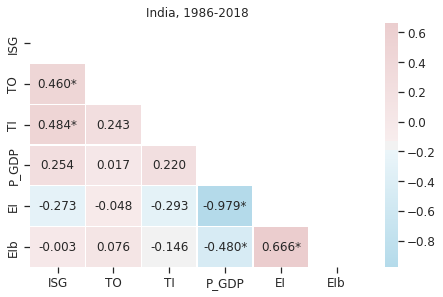

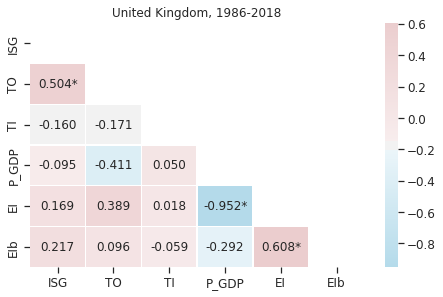

In [185]:
plot_corr(logdiff_data.xs('BGD', level='country').drop(columns='EIb'))
plt.title('Bangladesh, 1986-2018')
save_fig('_'.join(('BGD', 'current', 'correlations.pdf')))

plot_corr(logdiff_data.xs('IND', level='country'))
plt.title('India, 1986-2018')
save_fig('_'.join(('IND', 'current', 'correlations.pdf')))

plot_corr(logdiff_data.xs('GBR', level='country'))
plt.title('United Kingdom, 1986-2018')
save_fig('_'.join(('GBR', 'current', 'correlations.pdf')))

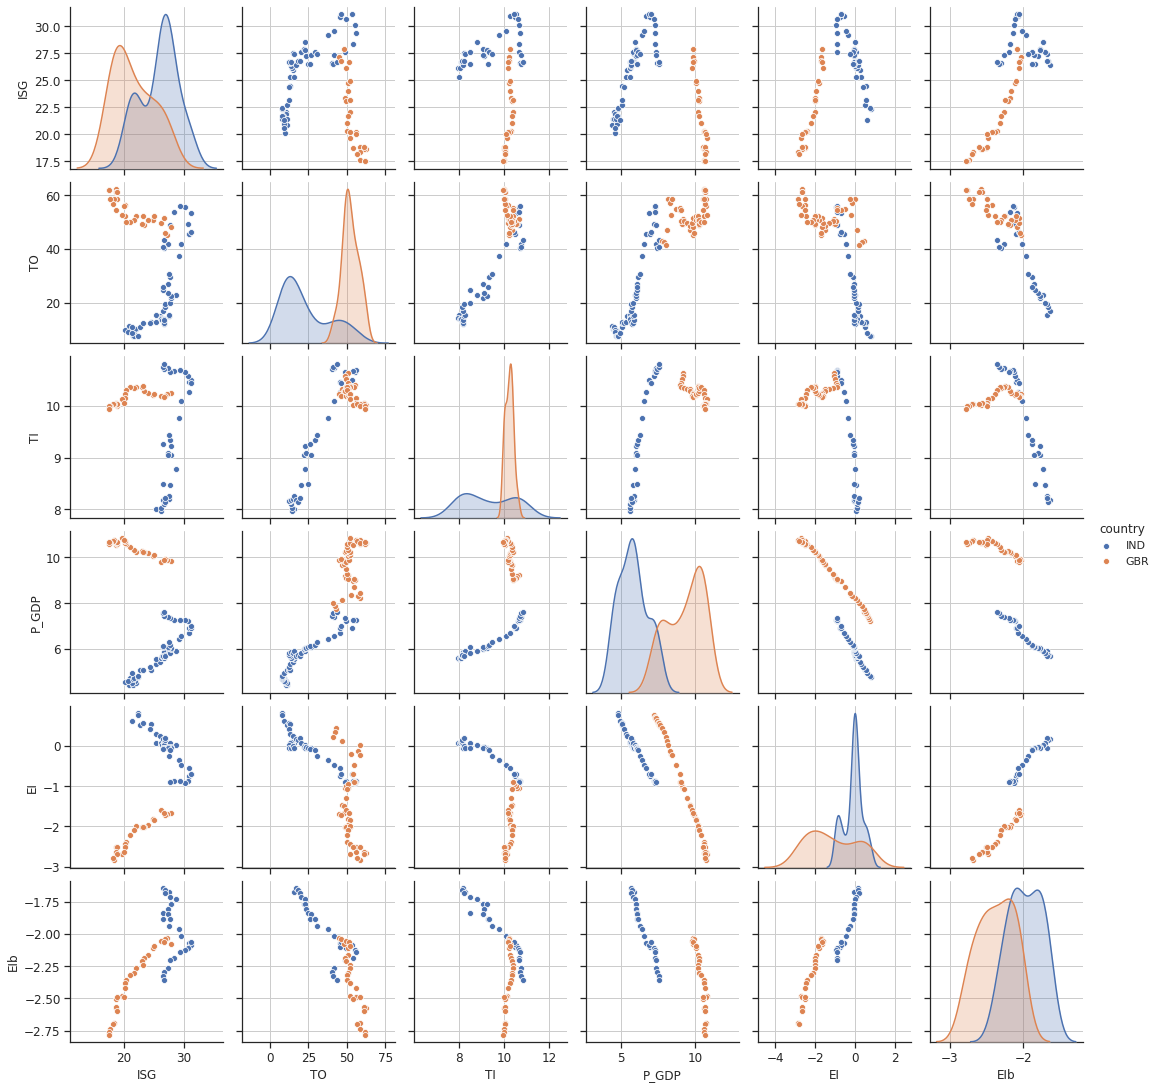

In [187]:
to_compare = log_data.loc[pd.IndexSlice[['GBR','IND'],:], :].reset_index().drop(columns='year')
sns.pairplot(to_compare, hue='country')

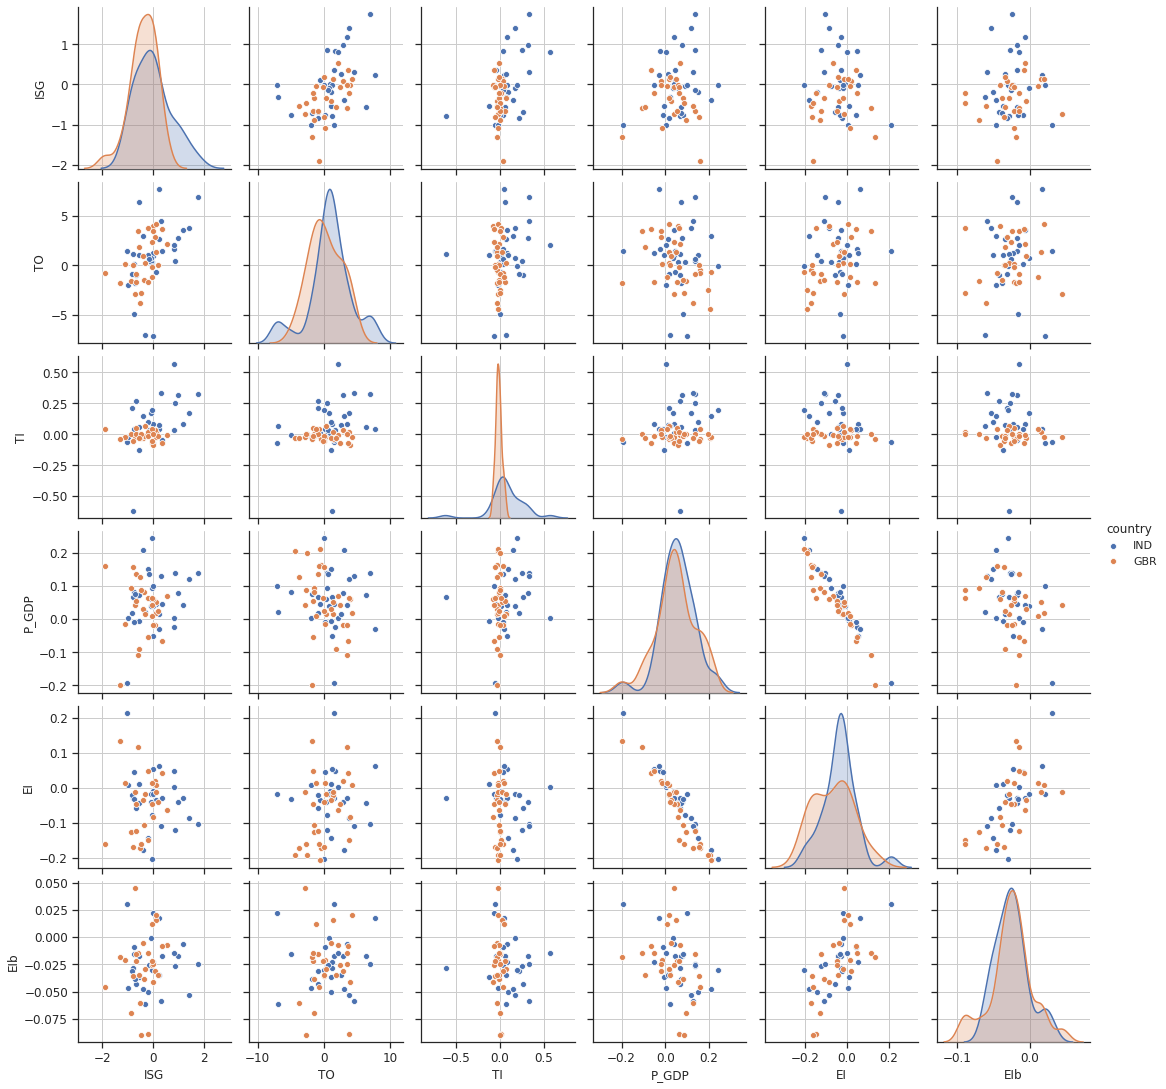

In [188]:
to_compare = logdiff_data.loc[pd.IndexSlice[['GBR','IND'],:], :].reset_index().drop(columns='year')
sns.pairplot(to_compare, hue='country')